## Download Data

In [1]:
# !pip install pyarrow gdown -qq

In [2]:
# !gdown --fuzzy 'https://drive.google.com/file/d/1mqtONldpayaQ97SH1p_UfdoH6nywVfYt/view?usp=sharing'

In [3]:
import pandas as pd

df = pd.read_parquet('detection_results_validation.parquet')
df

,filename,classid,score,x1,y1,x2,y2
0,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.971191,20,99,336,604
1,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.963867,342,0,664,609
2,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.945312,698,166,1008,864
3,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.931641,496,0,587,86
4,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.916992,50,91,123,185
...,...,...,...,...,...,...,...
142674,/workspace/yolo_v8_training/oiv7_full/validati...,3,0.865234,317,273,347,319
142675,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.922852,209,467,280,578
142676,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.859863,213,464,253,501
142677,/workspace/yolo_v8_training/oiv7_full/validati...,2,0.640625,265,493,284,510


In [4]:
# Create the mapping dictionary
label_map = {0: 'person', 1: 'head', 2: 'hand', 3: 'face'}

df['label'] = df['classid'].map(label_map)

In [5]:
df

,filename,classid,score,x1,y1,x2,y2,label
0,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.971191,20,99,336,604,person
1,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.963867,342,0,664,609,person
2,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.945312,698,166,1008,864,person
3,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.931641,496,0,587,86,head
4,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.916992,50,91,123,185,head
...,...,...,...,...,...,...,...,...
142674,/workspace/yolo_v8_training/oiv7_full/validati...,3,0.865234,317,273,347,319,face
142675,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.922852,209,467,280,578,person
142676,/workspace/yolo_v8_training/oiv7_full/validati...,1,0.859863,213,464,253,501,head
142677,/workspace/yolo_v8_training/oiv7_full/validati...,2,0.640625,265,493,284,510,hand


In [6]:
# Get rows with person label
df = df[df['label'] == 'person'] 
df

,filename,classid,score,x1,y1,x2,y2,label
0,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.971191,20,99,336,604,person
1,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.963867,342,0,664,609,person
2,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.945312,698,166,1008,864,person
13,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.889648,740,0,956,261,person
14,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.941406,213,0,1020,666,person
...,...,...,...,...,...,...,...,...
142662,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.958496,13,9,728,1024,person
142667,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.889160,371,445,421,593,person
142669,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.789551,268,124,300,148,person
142672,/workspace/yolo_v8_training/oiv7_full/validati...,0,0.941895,242,252,374,576,person


In [7]:
df = df.head(1000) # remove this!

## Convert Annotations to VOC

In [8]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
from xml.dom import minidom


def create_object_element(object_data):
    obj_elem = ET.Element('object')
    ET.SubElement(obj_elem, 'name').text = str(object_data['label'])
    ET.SubElement(obj_elem, 'pose').text = 'Unspecified'
    ET.SubElement(obj_elem, 'truncated').text = '0'
    ET.SubElement(obj_elem, 'difficult').text = '0'
    
    bndbox = ET.SubElement(obj_elem, 'bndbox')
    ET.SubElement(bndbox, 'xmin').text = str(object_data['x1'])
    ET.SubElement(bndbox, 'ymin').text = str(object_data['y1'])
    ET.SubElement(bndbox, 'xmax').text = str(object_data['x2'])
    ET.SubElement(bndbox, 'ymax').text = str(object_data['y2'])
    
    return obj_elem

def create_voc_xml(filename, objects, output_dir):
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'filename').text = os.path.basename(filename)
    
    image = Image.open(filename)
    width, height = image.size
    
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = str(len(image.getbands()))
    
    for object_data in objects:
        annotation.append(create_object_element(object_data))
    
    # Create a new XML document
    xml_str = ET.tostring(annotation, encoding='utf-8')
    dom = minidom.parseString(xml_str)
    
    # Pretty-print the XML with indentation
    pretty_xml = dom.toprettyxml(indent='    ')
    
    output_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(filename))[0]}.xml")
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)

In [9]:
import os
from tqdm.auto import tqdm

output_directory = 'pascal_voc_annotations'
os.makedirs(output_directory, exist_ok=True)

grouped_df = df.groupby('filename').apply(lambda x: x.to_dict('records')).reset_index(name='objects')


for row in tqdm(grouped_df.itertuples(index=False), total=len(grouped_df), desc='Generating annotations', unit=' imgs'):
    filename = row.filename
    objects = row.objects
    create_voc_xml(filename, objects, output_directory)

<ipython-input-9-e4a49b0192d3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df = df.groupby('filename').apply(lambda x: x.to_dict('records')).reset_index(name='objects')


Generating annotations:   0%|          | 0/242 [00:00<?, ? imgs/s]

## Plot XML file for verification

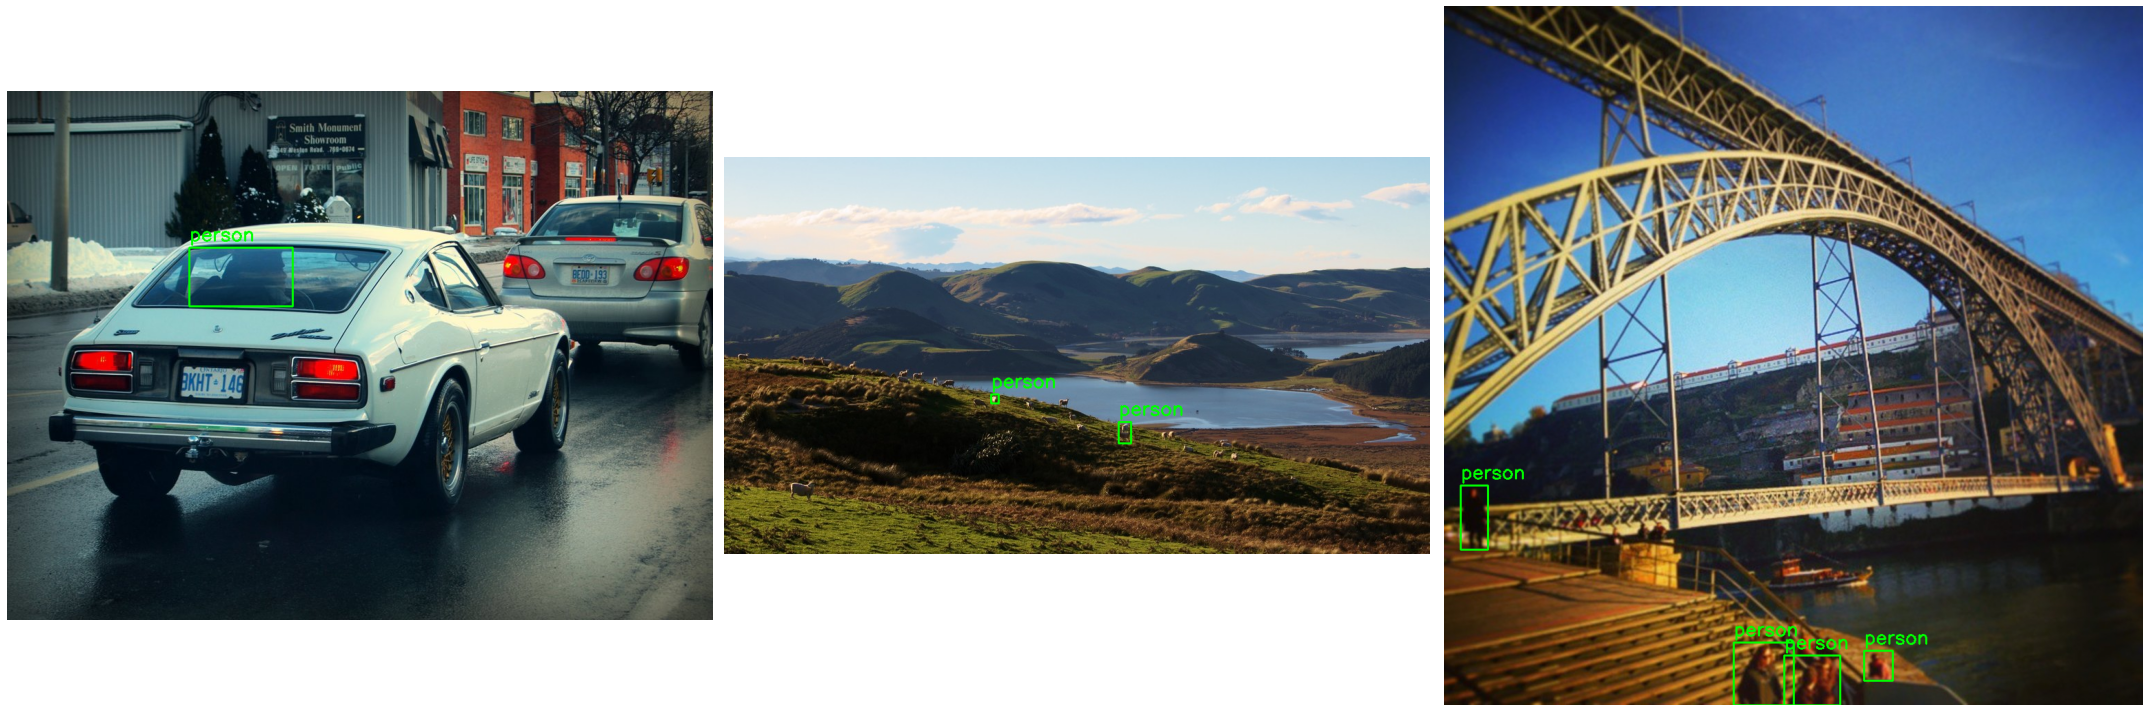

In [13]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def plot_random_image_with_bounding_boxes(xml_folder, image_folder, num_images):
    # Get the list of XML files in the folder
    xml_files = [file for file in os.listdir(xml_folder) if file.endswith('.xml')]
    
    # Randomly select num_images XML files
    random_xml_files = random.sample(xml_files, num_images)
    
    # Create a figure with subplots for each image
    fig, axes = plt.subplots(1, num_images, figsize=(10 * num_images, 10))
    
    # Iterate over the randomly selected XML files
    for i, xml_file in enumerate(random_xml_files):
        xml_path = os.path.join(xml_folder, xml_file)
        
        # Parse the XML file
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get the image filename from the XML
        image_filename = root.find('filename').text
        image_path = os.path.join(image_folder, image_filename)
        
        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Extract the bounding box information
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            class_id = obj.find('name').text
            
            # Draw the bounding box on the image
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            
            # Put the class ID text above the bounding box
            cv2.putText(image, class_id, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Plot the image with bounding boxes and class IDs in the corresponding subplot
        axes[i].imshow(image)
        axes[i].axis('off')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Display the plots
    plt.show()


image_folder = '/workspace/yolo_v8_training/oiv7_full/validation/'
xml_folder = 'pascal_voc_annotations/'

plot_random_image_with_bounding_boxes(xml_folder, image_folder, num_images=3)